# UCI machine learning repository

In [1]:
from matplotlib import pyplot as plt

from ada import *

## boston

In [2]:
(trainset, validset), (X_scaler, y_scaler) = get_dataset("boston", 50, True, True)
x_valid, y_valid = validset.tensors
features = x_valid.shape[-1]
x_valid.shape

torch.Size([91, 13])

In [3]:
x_valid.shape[0] / BINS

2.84375

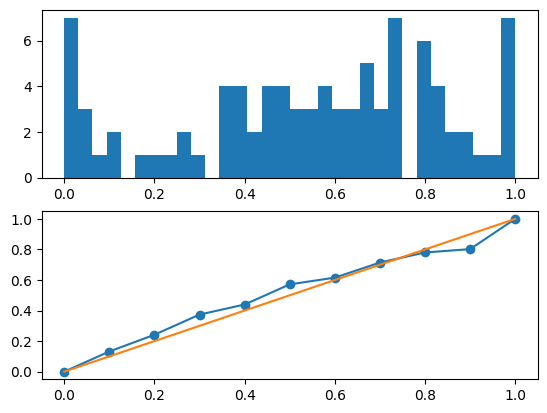

In [4]:
nn = NeuralNetwork(features, {"neurons": 7, "loss": "nll"})
nn.load("nll-1-1-4217")
y_nn = nn.predict(validset)
_, (ax1, ax2) = plt.subplots(nrows=2)
ax1.hist(normal_pit(*y_nn, y_valid).squeeze(), bins=BINS)
calibration_curve(ax2, normal_reliability(*y_nn, y_valid))

## concrete

In [5]:
(trainset, validset), (X_scaler, y_scaler) = get_dataset("concrete", 50, True, True)
x_valid, y_valid = validset.tensors
features = x_valid.shape[-1]
x_valid.shape

torch.Size([186, 8])

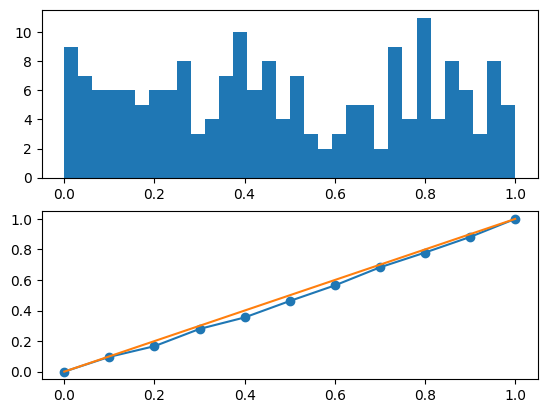

In [6]:
nn = NeuralNetwork(features, {"neurons": 8, "loss": "nll"})
nn.load("nll-1-1-4621")
y_nn = nn.predict(validset)
_, (ax1, ax2) = plt.subplots(nrows=2)
ax1.hist(normal_pit(*y_nn, y_valid).squeeze(), bins=BINS)
calibration_curve(ax2, normal_reliability(*y_nn, y_valid))

## energy

In [7]:
(trainset, validset), (X_scaler, y_scaler) = get_dataset("energy", 50, True, True)
x_valid, y_valid = validset.tensors
features = x_valid.shape[-1]
x_valid.shape

torch.Size([139, 8])

In [8]:
x_valid.shape[0] / BINS

4.34375

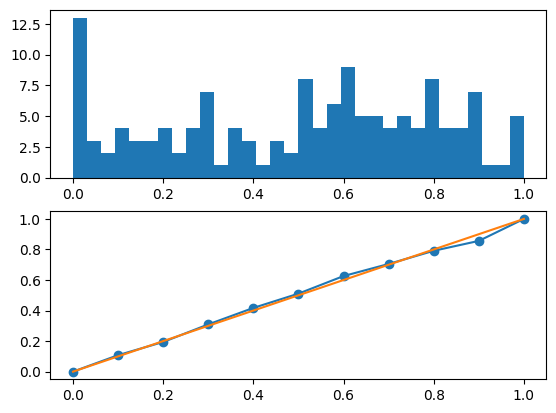

In [9]:
nn = NeuralNetwork(features, {"neurons": 8, "loss": "nll"})
nn.load("nll-1-1-1365")
y_nn = nn.predict(validset)
_, (ax1, ax2) = plt.subplots(nrows=2)
ax1.hist(normal_pit(*y_nn, y_valid).squeeze(), bins=BINS)
calibration_curve(ax2, normal_reliability(*y_nn, y_valid))

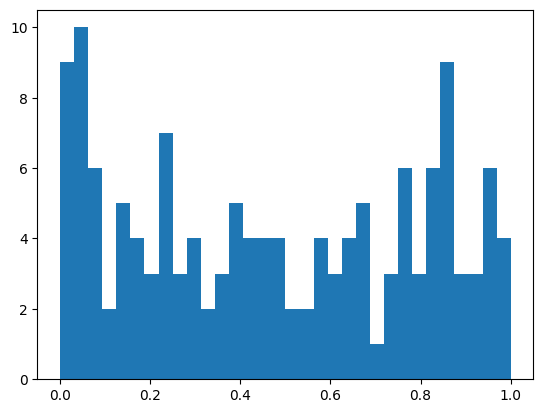

In [10]:
mdn = MixtureDensityNetwork(features, {"neurons": 8, "k": 5, "loss": "nll"})
mdn.load("nll-1-5-3643")
y_mdn = mdn.predict(validset)
plt.hist(gmm_pit(*y_mdn, y_valid).squeeze(), bins=BINS);

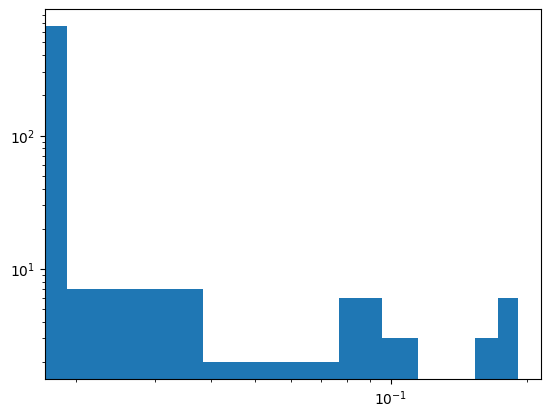

In [11]:
_, ax = plt.subplots()
ax.hist(y_mdn[-1].view(-1))
ax.set_xscale("log")
ax.set_yscale("log")

## kin8nm

In [12]:
(trainset, validset), (X_scaler, y_scaler) = get_dataset("kin8nm", 50, True, True)
x_valid, y_valid = validset.tensors
features = x_valid.shape[-1]
x_valid.shape

torch.Size([1475, 8])

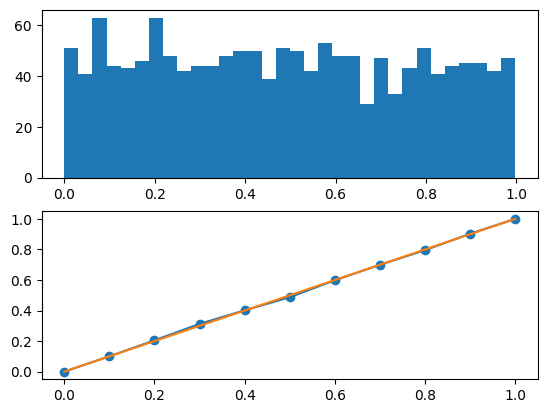

In [13]:
nn = NeuralNetwork(features, {"neurons": 8, "loss": "nll"})
nn.load("nll-1-1-7827")
y_nn = nn.predict(validset)
_, (ax1, ax2) = plt.subplots(nrows=2)
ax1.hist(normal_pit(*y_nn, y_valid).squeeze(), bins=BINS)
calibration_curve(ax2, normal_reliability(*y_nn, y_valid))

## naval

In [14]:
(trainset, validset), (X_scaler, y_scaler) = get_dataset("naval", 50, True, True)
x_valid, y_valid = validset.tensors
features = x_valid.shape[-1]
x_valid.shape, y_valid.shape

(torch.Size([2148, 16]), torch.Size([2148, 1]))

In [15]:
nn = NeuralNetwork(features, {"neurons": 13, "loss": "nll"})
nn.load("nll-1-1-4990")
y_nn = nn.predict(validset)
nn.metrics(y_nn, y_valid, y_scaler)

{'crps': 0.00017396322800777853,
 'mae': 0.0003906509664375335,
 'nll': -5.82125186920166,
 'pit': <wandb.sdk.data_types.histogram.Histogram at 0x7fbe96f8b7c0>,
 'rmse': 0.0006568480166606605,
 'sharpness': 3.266937369517109e-07,
 'variance': <wandb.sdk.data_types.histogram.Histogram at 0x7fbd886ee260>}

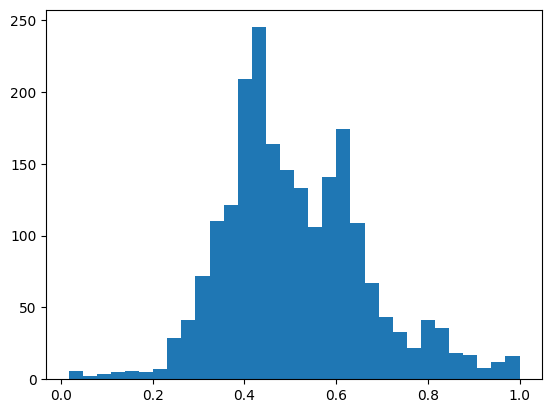

In [16]:
mean, variance = y_nn
plt.hist(normal_pit(
    y_scaler.inverse_transform(mean),
    y_scaler.inverse_transform_variance(variance),
    y_scaler.inverse_transform(y_valid)).squeeze(), bins=BINS);

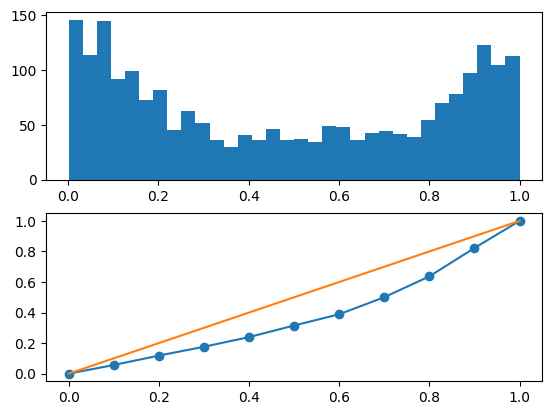

In [17]:
_, (ax1, ax2) = plt.subplots(nrows=2)
ax1.hist(normal_pit(*y_nn, y_valid).squeeze(), bins=BINS)
calibration_curve(ax2, normal_reliability(*y_nn, y_valid))

## power

In [18]:
(trainset, validset), (X_scaler, y_scaler) = get_dataset("power", 50, True, True)
x_valid, y_valid = validset.tensors
features = x_valid.shape[-1]
x_valid.shape, y_valid.shape

(torch.Size([1723, 4]), torch.Size([1723, 1]))

In [19]:
x_valid.shape[0] / BINS

53.84375

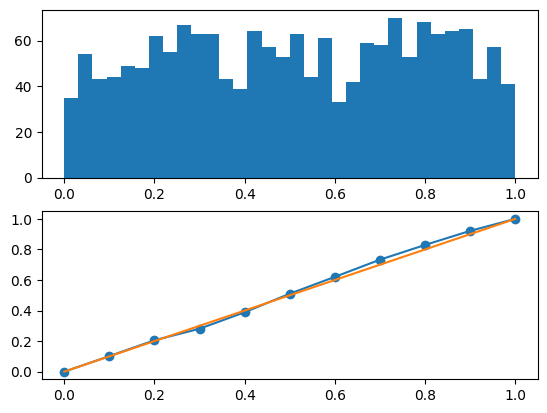

In [20]:
nn = NeuralNetwork(features, {"neurons": 4, "loss": "nll"})
nn.load("nll-1-1-8702")
y_nn = nn.predict(validset)
_, (ax1, ax2) = plt.subplots(nrows=2)
ax1.hist(normal_pit(*y_nn, y_valid).squeeze(), bins=BINS)
calibration_curve(ax2, normal_reliability(*y_nn, y_valid))

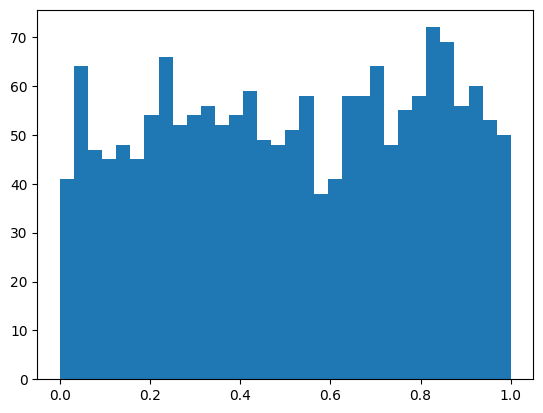

In [21]:
mdn = MixtureDensityNetwork(features, {"neurons": 4, "k": 2, "loss": "nll"})
mdn.load("nll-1-2-1858")
y_mdn = mdn.predict(validset)
plt.hist(gmm_pit(*y_mdn, y_valid).squeeze(), bins=BINS);

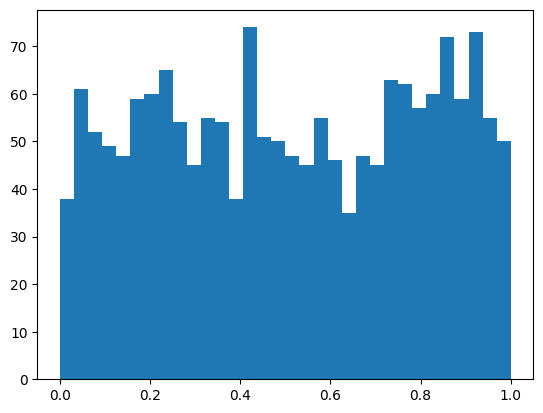

In [22]:
mdn = MixtureDensityNetwork(features, {"neurons": 4, "k": 3, "loss": "nll"})
mdn.load("nll-1-3-9155")
y_mdn = mdn.predict(validset)
plt.hist(gmm_pit(*y_mdn, y_valid).squeeze(), bins=BINS);

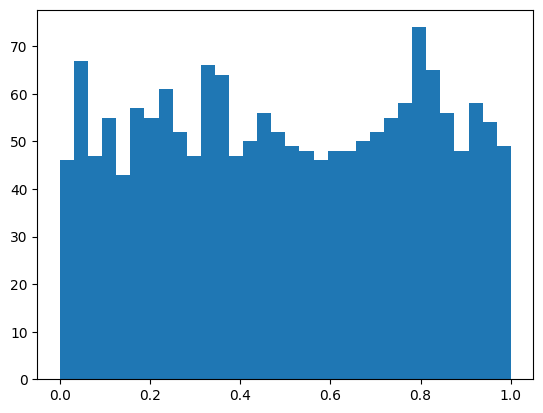

In [23]:
mdn = MixtureDensityNetwork(features, {"neurons": 4, "k": 4, "loss": "nll"})
mdn.load("nll-1-4-1301")
y_mdn = mdn.predict(validset)
plt.hist(gmm_pit(*y_mdn, y_valid).squeeze(), bins=BINS);

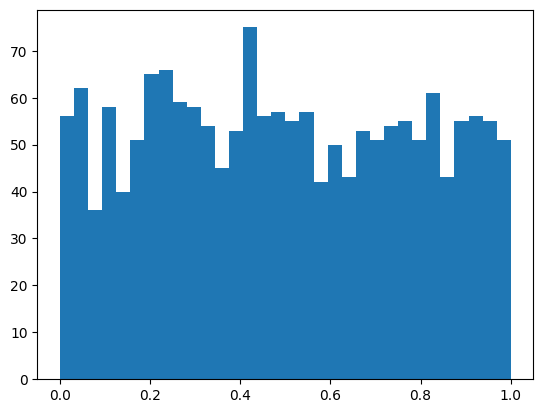

In [24]:
mdn = MixtureDensityNetwork(features, {"neurons": 4, "k": 5, "loss": "nll"})
mdn.load("nll-1-5-2332")
y_mdn = mdn.predict(validset)
plt.hist(gmm_pit(*y_mdn, y_valid).squeeze(), bins=BINS);

## protein

In [25]:
(trainset, validset), (X_scaler, y_scaler) = get_dataset("protein", 50, True, True)
x_valid, y_valid = validset.tensors
features = x_valid.shape[-1]
x_valid.shape, y_valid.shape

(torch.Size([8232, 9]), torch.Size([8232, 1]))

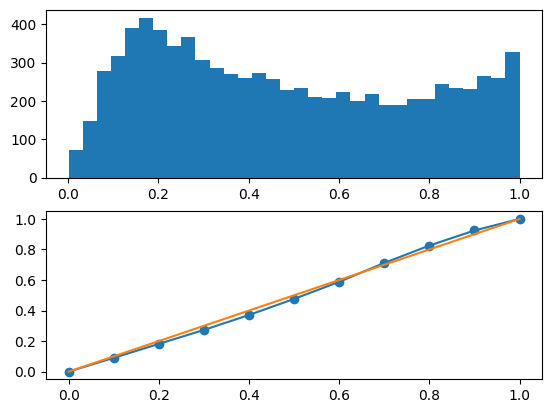

In [26]:
nn = NeuralNetwork(features, {"neurons": 8, "loss": "nll"})
nn.load("nll-1-1-5009")
y_nn = nn.predict(validset)
_, (ax1, ax2) = plt.subplots(nrows=2)
ax1.hist(normal_pit(*y_nn, y_valid).squeeze(), bins=BINS);
calibration_curve(ax2, normal_reliability(*y_nn, y_valid))

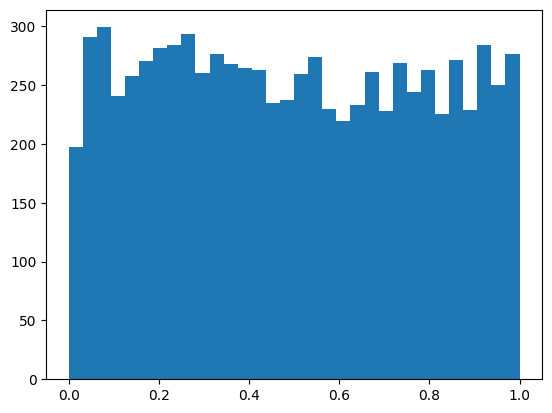

In [27]:
mdn = MixtureDensityNetwork(features, {"neurons": 8, "k": 5, "loss": "nll"})
mdn.load("nll-1-5-2964")
y_mdn = mdn.predict(validset)
plt.hist(gmm_pit(*y_mdn, y_valid).squeeze(), bins=BINS);

## wine

In [28]:
(trainset, validset), (X_scaler, y_scaler) = get_dataset("wine", 50, True, True)
x_valid, y_valid = validset.tensors
features = x_valid.shape[-1]
x_valid.shape, y_valid.shape

(torch.Size([288, 11]), torch.Size([288, 1]))

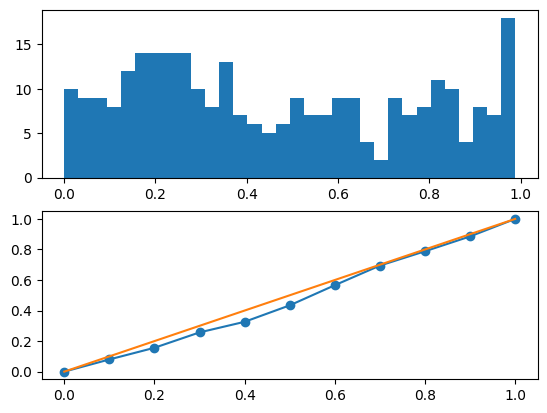

In [29]:
nn = NeuralNetwork(features, {"neurons": 5, "loss": "nll"})
nn.load("nll-1-1-9789")
y_nn = nn.predict(validset)
_, (ax1, ax2) = plt.subplots(nrows=2)
ax1.hist(normal_pit(*y_nn, y_valid).squeeze(), bins=BINS)
calibration_curve(ax2, normal_reliability(*y_nn, y_valid))

## yacht

In [30]:
(trainset, validset), (X_scaler, y_scaler) = get_dataset("yacht", 50, True, True)
x_valid, y_valid = validset.tensors
features = x_valid.shape[-1]
x_valid.shape, y_valid.shape

(torch.Size([56, 6]), torch.Size([56, 1]))

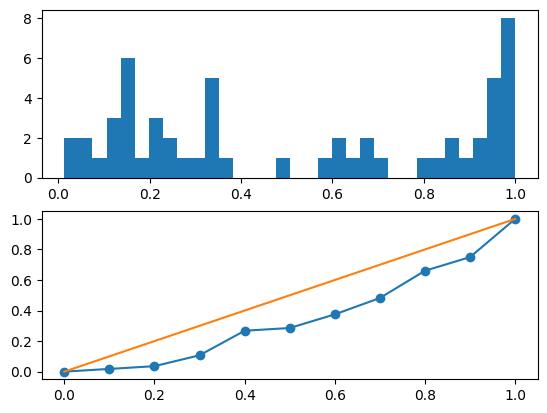

In [31]:
nn = NeuralNetwork(features, {"neurons": 6, "loss": "nll"})
nn.load("nll-1-1-1383")
y_nn = nn.predict(validset)
_, (ax1, ax2) = plt.subplots(nrows=2)
ax1.hist(normal_pit(*y_nn, y_valid).squeeze(), bins=BINS)
calibration_curve(ax2, normal_reliability(*y_nn, y_valid))

## year

In [32]:
(trainset, validset), (X_scaler, y_scaler) = get_dataset("year", 50, True, True)
x_valid, y_valid = validset.tensors
features = x_valid.shape[-1]
x_valid.shape, y_valid.shape

(torch.Size([92762, 90]), torch.Size([92762, 1]))

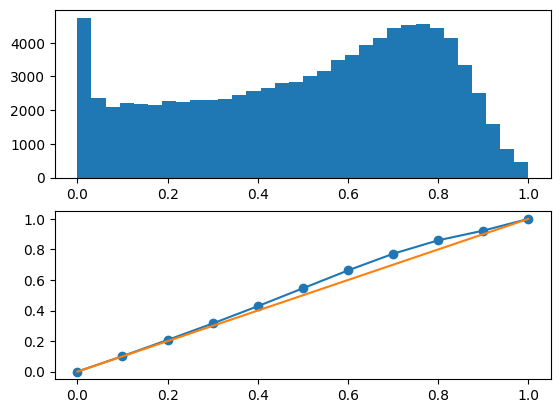

In [33]:
nn = NeuralNetwork(features, {"neurons": 64, "loss": "nll"})
nn.load("nll-1-1-9895")
y_nn = nn.predict(validset)
_, (ax1, ax2) = plt.subplots(nrows=2)
ax1.hist(normal_pit(*y_nn, y_valid).squeeze(), bins=BINS)
calibration_curve(ax2, normal_reliability(*y_nn, y_valid))

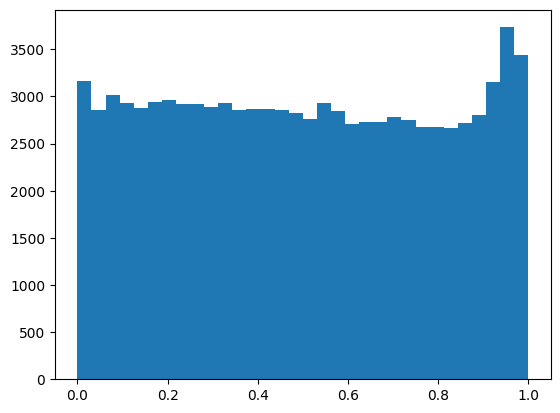

In [34]:
mdn = MixtureDensityNetwork(features, {"neurons": 64, "k": 5, "loss": "nll"})
mdn.load("nll-1-5-4615")
y_mdn = mdn.predict(validset)
plt.hist(gmm_pit(*y_mdn, y_valid).squeeze(), bins=BINS);

## sofplus versus exponential functions

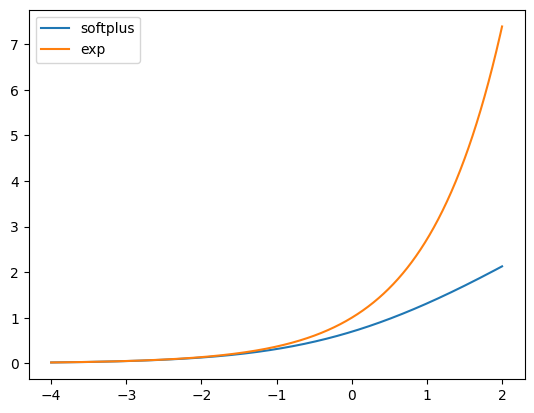

In [35]:
x = torch.linspace(-4, 2, steps=1024)
_, ax = plt.subplots()
ax.plot(x, F.softplus(x), label="softplus")
ax.plot(x, torch.exp(x), label="exp")
ax.legend()